# Test weights generated by train.ipynb

Based on https://github.com/RussTedrake/manipulation/blob/master/segmentation_inference.ipynb

This does not generate new data from simulation (it loads from the train dataset).  Techically speaking the model could be overfit so we really should
use new data, but this gives a good idea of whether the model is doing anything.

In [2]:
# Imports
import os.path as osp

import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as Tf

from chess_bot.utils.path_util import get_chessbot_src

In [3]:
dataset_path = osp.join(get_chessbot_src(), 'resources/training_data')

# ycb = [
#     "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
#     "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
# ]

pieces = [
    'BB', # : 'Bishop_B.urdf',
    'BW', # : 'Bishop_W.urdf',

    'KB', # : 'King_B.urdf',
    'KW', # : 'King_W.urdf',

    'NB', # : 'Knight_B.urdf',
    'NW', # : 'Knight_W.urdf',

    'PB', # : 'Pawn_B.urdf',
    'PW', # : 'Pawn_W.urdf',

    'QB', # : 'Queen_B.urdf',
    'QW', # : 'Queen_W.urdf',

    'RB', # : 'Rook_B.urdf',
    'RW', # : 'Rook_W.urdf'
]

def get_piece_from_label(label):
    return pieces[label - 1]

num_images = len(fnmatch.filter(os.listdir(dataset_path),'*.png'))
def open_image(idx):
    filename = os.path.join(dataset_path, f"board_{idx:05d}.png")
    return Image.open(filename).convert("RGB")

# model_file = 'weights/L_chess_maskrcnn_model_ep_15.pt'
# model_file = 'weights/chess_maskrcnn_model_10p.pt'  # 10 pieces
# model_file = 'weights/chess_maskrcnn_model_rp.pt'  # random num pieces
model_file = osp.join(get_chessbot_src(), 'resources/weights/chess_maskrcnn_model_ror.pt')  # Higher angle and random orient

In [4]:
%%capture

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

num_classes = len(pieces)+1
model = get_instance_segmentation_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')
model.load_state_dict(
    torch.load(model_file, map_location=device))
model.eval()

model.to(device)

In [5]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(952)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

In [6]:
prediction


[{'boxes': tensor([[ 451.6576,  836.5956,  562.6897, 1001.4248],
          [1259.4115,  267.2520, 1338.5010,  404.5998],
          [ 342.6212,  570.4198,  450.0062,  721.0643],
          [1115.0319,  186.7798, 1194.8633,  319.0249],
          [ 850.3077,  267.0659,  932.1760,  405.1391],
          [ 699.7706,  358.3015,  787.2192,  499.9700],
          [1139.9170,  457.6060, 1232.5111,  603.9618],
          [ 652.9125,  693.4193,  756.4046,  852.7969],
          [1331.1473,  693.4104, 1436.3370,  853.0521],
          [ 823.6840,  693.8468,  925.3593,  851.3959],
          [ 992.1066,  569.0590, 1087.2306,  721.1116],
          [ 735.2480,  114.0196,  810.3607,  241.9346],
          [ 686.2520,  457.6956,  778.1343,  603.6160],
          [1162.2887,  694.1774, 1265.6932,  851.9335],
          [ 485.6188,  112.9045,  561.1144,  242.5629],
          [1273.8175,  359.0111, 1357.3448,  497.3150],
          [ 368.4839,  419.2328,  480.5130,  605.2641],
          [1529.5454,  794.0264, 1672.3

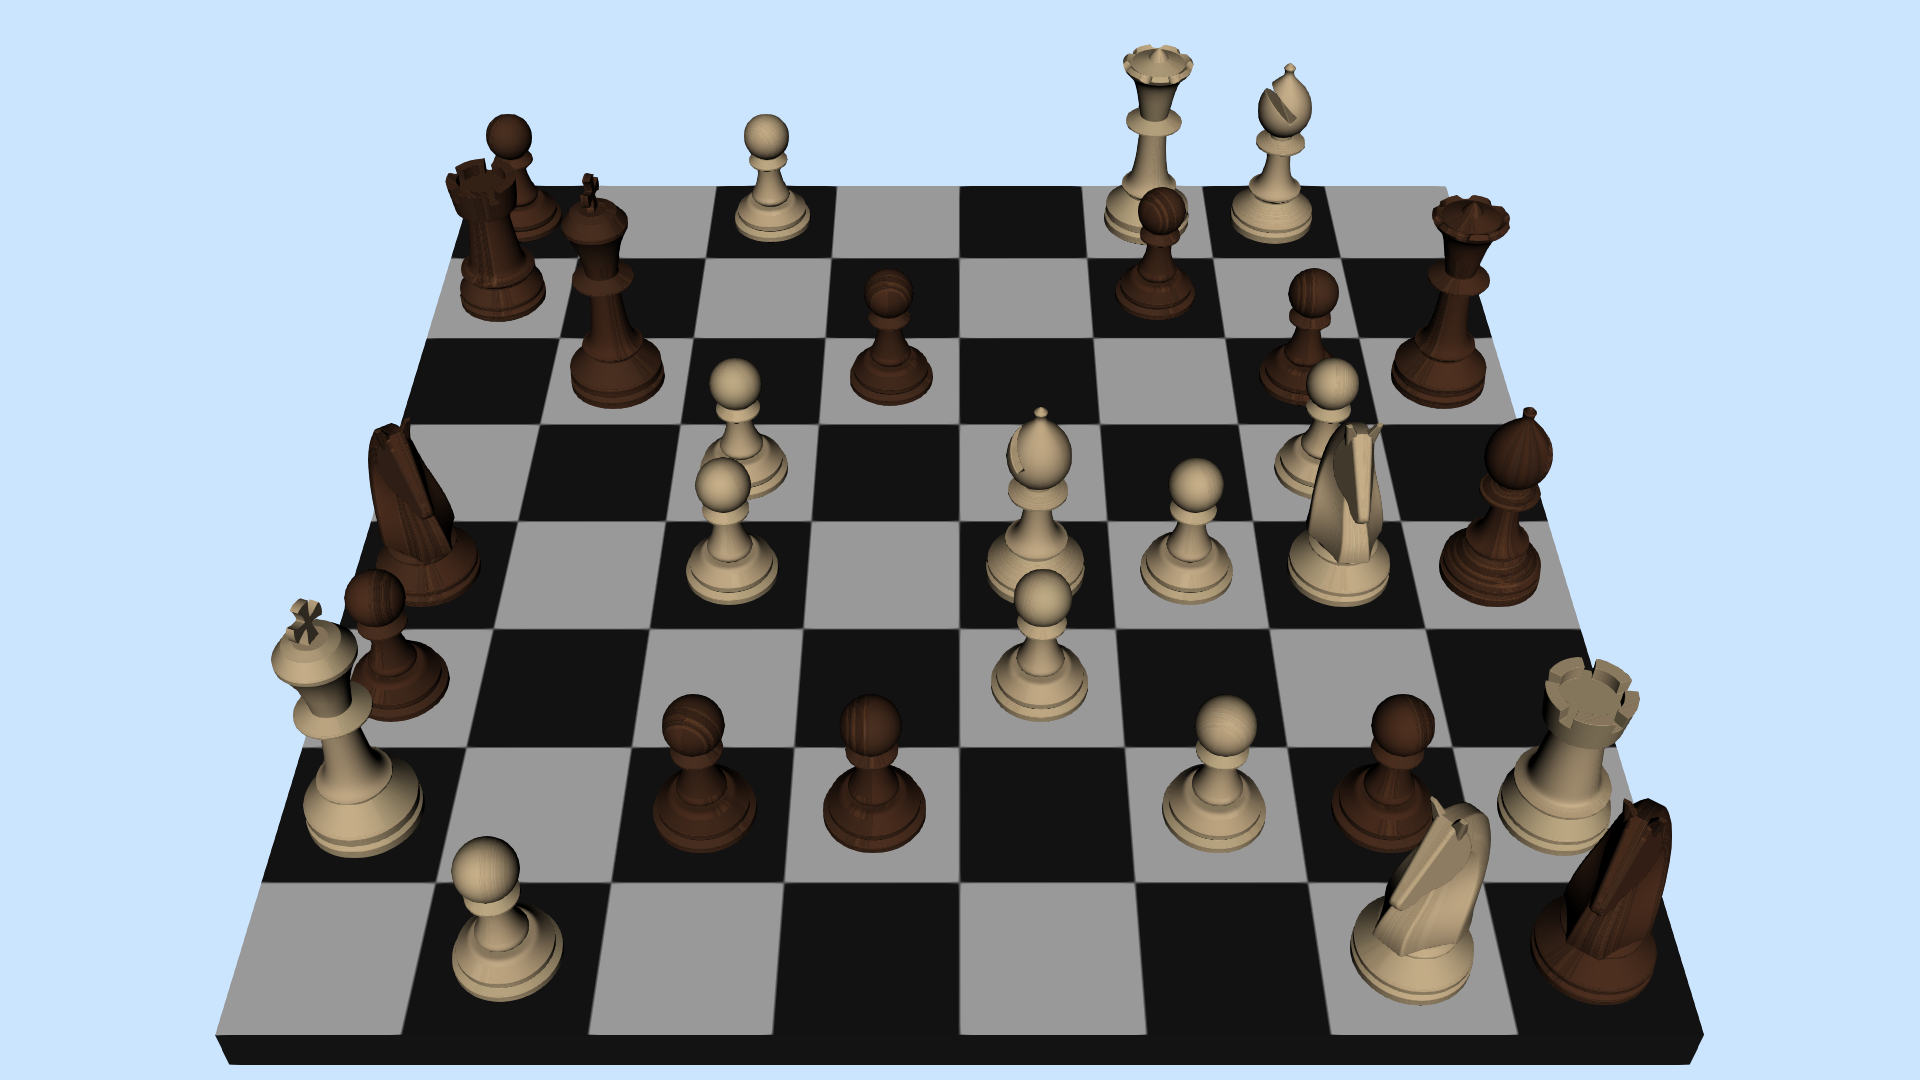

In [7]:
img

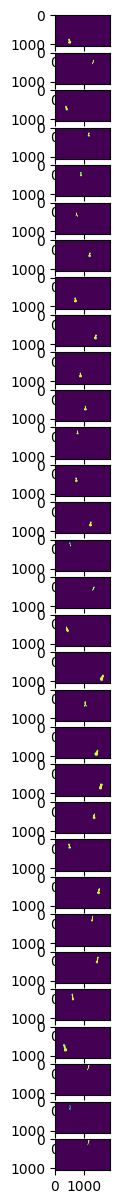

In [8]:
N = prediction[0]['masks'].shape[0]
fig, ax = plt.subplots(N, 1, figsize=(15, 15))
for n in range(prediction[0]['masks'].shape[0]):
    ax[n].imshow(
        np.asarray(
            Image.fromarray(
                prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy())))

In [10]:
import matplotlib.patches as patches
import random

def plot_prediction():
    thresh = 0.97
    img_np = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img_np)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 60)]

    num_instances = prediction[0]['boxes'].shape[0]
    bbox_colors = random.sample(colors, num_instances)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().detach().numpy()

    for i in range(num_instances):
        if scores[i] < thresh:
            continue
        color = bbox_colors[i]
        bb = boxes[i,:]
        bbox = patches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1],
                linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(bb[0], bb[1], s=get_piece_from_label(labels[i]), 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        plt.text(bb[0], bb[3], s=str(f'{scores[i]:.3}'), 
                color='white', verticalalignment='bottom',
                bbox={'color': color, 'pad': 0})
    plt.axis('off');

# plot_prediction()

## Pick and visualize image

### Random board

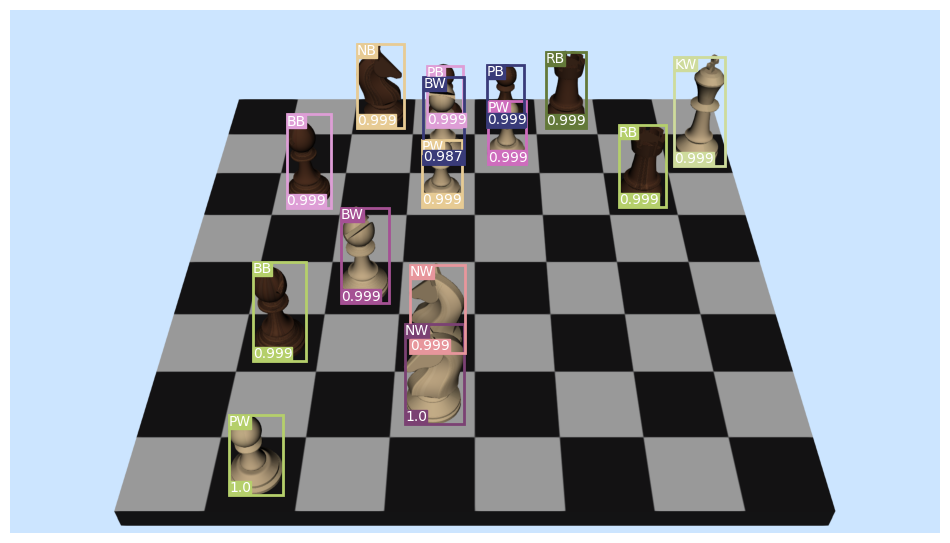

In [11]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(999)  # 9 has worst case (queen in front of pawn)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])


plot_prediction()

### Starting board

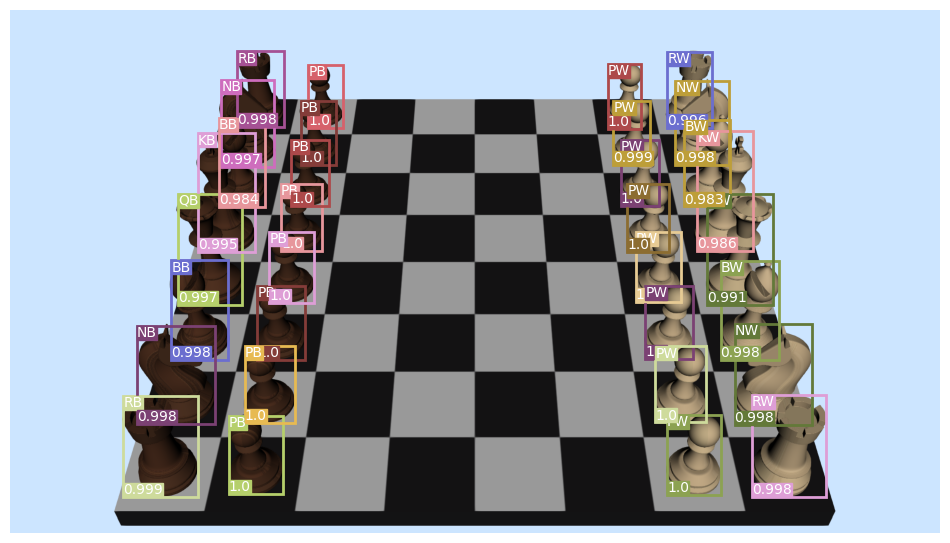

In [13]:
filename = os.path.join(dataset_path, f"board_start.png")
img = Image.open(filename).convert("RGB")

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])


plot_prediction()

### Show prediction confidence

In [14]:
labels = list(prediction[0]['labels'].cpu().detach().numpy())
scores = list(prediction[0]['scores'].cpu().detach().numpy()) 

for i, label in enumerate(labels):
    print(i, label, get_piece_from_label(label), scores[i])

0 7 PB 0.9997732
1 7 PB 0.99975973
2 7 PB 0.9997422
3 8 PW 0.9997334
4 7 PB 0.99971384
5 7 PB 0.99971086
6 8 PW 0.99968576
7 8 PW 0.99968255
8 7 PB 0.9996666
9 8 PW 0.99966633
10 8 PW 0.9996488
11 8 PW 0.9996481
12 7 PB 0.99962246
13 7 PB 0.9995906
14 8 PW 0.9995789
15 8 PW 0.9994759
16 11 RB 0.9992142
17 11 RB 0.9984835
18 6 NW 0.9982533
19 6 NW 0.99814725
20 1 BB 0.99809736
21 5 NB 0.99781644
22 12 RW 0.9975916
23 2 BW 0.9975721
24 9 QB 0.99705625
25 5 NB 0.9969156
26 12 RW 0.995535
27 3 KB 0.9945971
28 10 QW 0.99115235
29 4 KW 0.9863594
30 1 BB 0.98425967
31 2 BW 0.9828029
32 4 KW 0.96249413
33 6 NW 0.8562347
34 3 KB 0.57100713
35 4 KW 0.44471946
36 10 QW 0.25712717
37 4 KW 0.1478685
38 5 NB 0.13250822
39 6 NW 0.10044628
40 12 RW 0.08050255
41 2 BW 0.08004767
42 3 KB 0.060374513
